In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import itertools
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import os

In [2]:
train_path = 'fruits-360/Training'
test_path = 'fruits-360/Test'
classes = ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion Red Peeled', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Plum 2', 'Plum 3', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Potato Red Washed', 'Potato Sweet', 'Potato White', 'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Heart', 'Tomato Maroon', 'Tomato not Ripened', 'Tomato Yellow', 'Walnut', 'Watermelon']

In [3]:
#Data augmentation and validation split
train_datagen = ImageDataGenerator(shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

batch_size=50

train_batches = train_datagen.flow_from_directory(train_path, target_size=(100,100), classes=classes, batch_size=batch_size, subset='training')
validation_batches = train_datagen.flow_from_directory(train_path, target_size=(100,100), classes=classes, batch_size=batch_size, subset='validation')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(100,100), classes=classes, batch_size=batch_size)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Build and train CNN

In [4]:
dropout_rate = 0.5

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(100,100,3), padding='valid'),#100x100
    MaxPooling2D(pool_size=(2, 2), strides=2),#98x98x16
    Conv2D(32, (3,3), activation='relu', padding='valid'),#49x49x16
    MaxPooling2D(pool_size=(2, 2), strides=2),#47x47x32
    Conv2D(64, (3,3), activation='relu', padding='valid'),#23x23x32
    MaxPooling2D(pool_size=(2, 2), strides=2),#21x21x64
    Conv2D(128, (3,3), activation='relu', padding='valid'),#10x10x64
    MaxPooling2D(pool_size=(2, 2), strides=2),#8x8x128
    Conv2D(256, (3,3), activation='relu', padding='valid'),#4x4x128
    Flatten(),#4x4x256
    Dense(2048, activation='relu'),#4096
    Dropout(dropout_rate),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(131, activation='softmax'),
])

In [5]:
learning_rate=.00005
loss_function='categorical_crossentropy'
model.compile(Adam(lr=learning_rate), loss=loss_function, metrics=['accuracy'])

In [6]:
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
iter_count=0

In [7]:
if not os.path.exists("models/scratch"+dt_string):
    os.mkdir("models/scratch/"+dt_string)
    
summary_file = open("models/scratch/"+dt_string+"/summary.txt", "w")

def printModelSummaryToFile(line):
    summary_file.write(line+"\n")

In [8]:
model.summary(print_fn=printModelSummaryToFile)
summary_file.write("\nLearning Rate: "+str(learning_rate)+"\n")
summary_file.write("Loss Function: "+str(loss_function)+"\n")
summary_file.write("Dropout Rate: "+str(dropout_rate)+"\n")
summary_file.write("Batch Size: "+str(batch_size)+"\n")
summary_file.close()

#Callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)
mc = ModelCheckpoint("models/scratch/"+dt_string+"/"+dt_string+"_best.h5", monitor='val_accuracy', mode='max', save_best_only=True)

start_time = datetime.now()

history = model.fit(x=train_batches, validation_data=validation_batches, epochs=999, verbose=2, callbacks=[es, mc])

end_time = datetime.now()
time_delta =(end_time-start_time).total_seconds()

summary_file = open("models/scratch/"+dt_string+"/summary.txt", "a")
summary_file.write("Time Train Start: "+str(start_time)+"\n")
summary_file.write("Time Train End: "+str(end_time)+"\n")
summary_file.write("Time Delta: "+str(time_delta)+"\n")
summary_file.close()

model.save("models/scratch/"+dt_string+"/"+dt_string+"_last.h5")

Epoch 1/999
1084/1084 - 130s - loss: 3.3618 - accuracy: 0.2530 - val_loss: 0.9604 - val_accuracy: 0.7856
Epoch 2/999
1084/1084 - 129s - loss: 0.9652 - accuracy: 0.7200 - val_loss: 0.4393 - val_accuracy: 0.8839
Epoch 3/999
1084/1084 - 130s - loss: 0.4274 - accuracy: 0.8671 - val_loss: 0.3072 - val_accuracy: 0.9205
Epoch 4/999
1084/1084 - 130s - loss: 0.2411 - accuracy: 0.9244 - val_loss: 0.3036 - val_accuracy: 0.9275
Epoch 5/999
1084/1084 - 128s - loss: 0.1529 - accuracy: 0.9503 - val_loss: 0.2325 - val_accuracy: 0.9502
Epoch 6/999
1084/1084 - 128s - loss: 0.1055 - accuracy: 0.9662 - val_loss: 0.2573 - val_accuracy: 0.9449
Epoch 7/999
1084/1084 - 129s - loss: 0.0798 - accuracy: 0.9738 - val_loss: 0.2666 - val_accuracy: 0.9464
Epoch 8/999
1084/1084 - 129s - loss: 0.0671 - accuracy: 0.9778 - val_loss: 0.2291 - val_accuracy: 0.9533
Epoch 9/999
1084/1084 - 128s - loss: 0.0520 - accuracy: 0.9834 - val_loss: 0.2515 - val_accuracy: 0.9573
Epoch 10/999
1084/1084 - 128s - loss: 0.0425 - accuracy

# Prediction

In [9]:
best_model = load_model("models/scratch/"+dt_string+"/"+dt_string+"_best.h5")

In [10]:
test_imgs, test_labels = next(test_batches)

In [11]:
test_labels = np.argmax(test_labels, axis=-1)
test_labels

array([ 92,  25, 120, 124,   5, 117,  18, 104,  27,  34, 102,  81, 122,
        46,  47,  88,  67,   8, 114,  25, 104,  83,   9, 129,  21,  17,
         5,   5,  63,  83,  62,  99,  80,   8,  83,  55,  28, 121,  41,
        25,  44,  22,  28,  69,  23, 120,  41,  83, 118, 119], dtype=int64)

In [12]:
predictions = np.argmax(best_model.predict(x=test_imgs, steps=1, verbose=0), axis=-1)

In [13]:
predictions

array([ 92,  25, 120, 124,   5, 117,  18, 104,  27,  34, 102,  81, 122,
        46,  47,  88,  67,   8, 114,  25, 104,  83,   9, 129,  21,  35,
         5,   5,  63,  83,  62,  99,  80,   8,  83,  55,  28, 121,  41,
        25,  44,  22,  28,  69,  23, 120,  41,  83, 118, 119], dtype=int64)

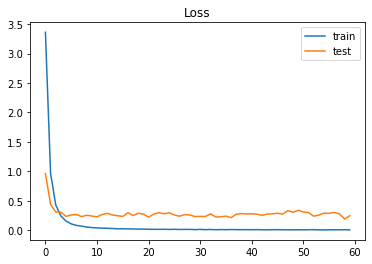

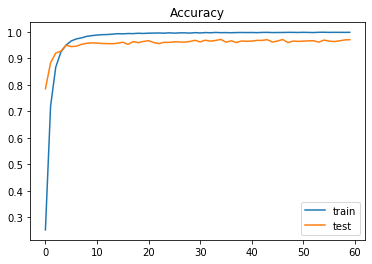

In [18]:
# plot training history
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig("models/scratch/"+dt_string+"/loss_history.png", bbox_inches='tight')
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.savefig("models/scratch/"+dt_string+"/accuracy_history.png", bbox_inches='tight')
plt.show()

In [15]:
# evaluate the model
_, train_acc = best_model.evaluate(train_batches, verbose=1)
_, test_acc = best_model.evaluate(test_batches, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
summary_file = open("models/scratch/"+dt_string+"/summary.txt", "a")
summary_file.write("Train Accuracy: "+str(train_acc)+"\n")
summary_file.write("Test Accuracy: "+str(test_acc)+"\n")
summary_file.close()

454/454 [==============================] - 10s 22ms/step - loss: 0.1847 - accuracy: 0.9693
Train: 1.000, Test: 0.969


In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7